# Manually pick the arrival phases

### This is the class that is the picker

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, Button, VBox, Output, Dropdown
import datetime

class SeismicPicker:
    def __init__(self, time, amplitude):
        self.time = np.array(time, dtype='datetime64[ms]')  # Ensure time is in datetime64
        self.start_time = self.time[0]
        self.time_seconds = (self.time - self.start_time) / np.timedelta64(1, 's')  # Convert to seconds
        
        self.amplitude = amplitude  # Shape: (time, stations)
        self.num_stations = amplitude.shape[1]
        self.picks = {i: None for i in range(self.num_stations)}
        
        self.fig, self.ax = plt.subplots()
        self.current_station = 0
        self.line = None  # To store the pick line
        
        self.station_selector = Dropdown(
            options=[(f'Station {i}', i) for i in range(self.num_stations)],
            value=0,
            description='Station:'
        )
        self.slider = FloatSlider(
            min=self.time_seconds.min(), max=self.time_seconds.max(), 
            step=(self.time_seconds.max()-self.time_seconds.min())/100, 
            value=self.time_seconds[0], 
            description='Pick Time (s)'
        )
        self.button = Button(description='Confirm Pick')
        self.output = Output()
        
        self.station_selector.observe(self.change_station, names='value')
        self.slider.observe(self.update_pick, names='value')
        self.button.on_click(self.confirm_pick)
        
        display(VBox([self.station_selector, self.slider, self.button, self.output]))
        
        self.plot_station(self.current_station)
        plt.show()
        
    def plot_station(self, station):
        """Updates the plot when switching stations"""
        self.ax.clear()  # Clear previous plot
        self.ax.plot(self.time, self.amplitude[:, station], label=f'Seismic Trace (Station {station})')

        # If there's a previous pick for this station, use it; otherwise, default to first time
        pick_time = self.picks[station] if self.picks[station] is not None else self.time[0]
        
        # Remove old pick line if it exists
        if self.line is not None:
            self.line.remove()
        
        # Draw new pick line
        self.line = self.ax.axvline(pick_time, color='r', linestyle='--', label='Pick')
        
        self.ax.set_xlabel('Time')
        self.ax.set_ylabel('Amplitude')
        self.ax.legend()
        
        # Force an update
        self.fig.canvas.draw_idle()
        
    def change_station(self, change):
        """Handles switching between stations and updating pick display."""
        self.current_station = change['new']
        self.plot_station(self.current_station)  # Replot for new station
        
        # Update slider to the last pick for this station, or reset if none
        if self.picks[self.current_station] is not None:
            self.slider.value = (self.picks[self.current_station] - self.start_time) / np.timedelta64(1, 's')
        else:
            self.slider.value = self.time_seconds[0]
        
    def update_pick(self, change):
        """Updates the pick line position dynamically."""
        pick_time = self.start_time + np.timedelta64(int(self.slider.value * 1000), 'ms')
        self.line.set_xdata([pick_time, pick_time])
        self.fig.canvas.draw_idle()  # Force an update
        
    def confirm_pick(self, _):
        """Confirms the pick and stores it."""
        pick_time = self.start_time + np.timedelta64(int(self.slider.value * 1000), 'ms')
        self.picks[self.current_station] = pick_time
        with self.output:
            self.output.clear_output()
            print(f'Pick for Station {self.current_station} confirmed at {pick_time}')
            print(f'All picks: {self.get_picks()}')
        
    def get_picks(self):
        """Returns all confirmed picks as a list of [station, pick_time]."""
        return [[station, time] for station, time in self.picks.items() if time is not None]




### Import other necessary functions

In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from glob import glob
from scipy import signal
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import detrend
from tqdm import tqdm
import pickle as pkl
from sklearn import neighbors
import copy
from sklearn.cluster import DBSCAN
import emcee
import pandas as pd
import rasterio
from rasterio.plot import show
from scipy.stats import gaussian_kde

from datetime import timedelta
import datetime
import numpy as np
import matplotlib.dates as mdates
import matplotlib


def sintela_to_datetime(sintela_times):
    '''
    returns an array of datetime.datetime 
    ''' 
    
    days1970 = datetime.datetime.date(datetime.datetime(1970, 1, 1)).toordinal()

    # Vectorize everything
    converttime = np.vectorize(datetime.datetime.fromordinal)
    addday_lambda = lambda x : datetime.timedelta(days=x)
    adddays = np.vectorize(addday_lambda )
    
    day = days1970 + sintela_times/1e6/60/60/24
    thisDateTime = converttime(np.floor(day).astype(int))
    dayFraction = day-np.floor(day)
    thisDateTime = thisDateTime + adddays(dayFraction)

    return thisDateTime

def preprocessing_step(file):

    # Load data #
    f = h5py.File(file)
    attrs = f['Acquisition'].attrs
    data = f['Acquisition']['Raw[0]']['RawData'][:]
    this_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
    times = sintela_to_datetime(this_time)
    x = np.linspace(0,data.shape[1],data.shape[1]) * attrs['SpatialSamplingInterval']
    

    fs = attrs['PulseRate'] #sample rate

    #filter
    sos = signal.butter(10, [1,500], 'bp', fs=fs, output='sos')
    filtered = signal.sosfiltfilt(sos, data, axis=0)


    if file[-9:-7] != '00':
        time_start = times[0] - datetime.timedelta(seconds=times[0].second, microseconds=times[0].microsecond)
        forward_step = np.arange(time_start, times[0], 500).shape[0]
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500]) + forward_step -1
    else:
        data_locator = np.array([int(i) for i in (this_time-this_time[0])/500])



    # this_time = np.arange(0,int(fs*60))* 500 + this_time[0]
    # print(this_time)


    filled_data = np.zeros((int(fs*60),filtered.shape[1]))
    filled_times = np.zeros((int(fs*60)), dtype=object)


    filled_times[data_locator] = times
    filled_data[data_locator] = filtered
    filt_filled_data = filled_data[:,:]

    return filt_filled_data, filled_times, attrs


def remove_nearby_datetimes(datetime_list, threshold_seconds):
    """
    Removes datetime values from a list that are within a specified time threshold of each other.

    Args:
        datetime_list: A list of datetime objects.
        threshold_seconds: The threshold in seconds to consider datetimes as "near" each other.

    Returns:
        A new list with the nearby datetimes removed.
    """
    if not datetime_list:
        return []

    datetime_list.sort()  # Ensure datetimes are in chronological order
    result = [datetime_list[0]]
    last_added = datetime_list[0]

    for dt in datetime_list[1:]:
        if (dt - last_added).total_seconds() > threshold_seconds:
            result.append(dt)
            last_added = dt

    return result

def group_seismic_detections(detections, space_threshold, time_threshold_seconds):
    """
    Groups seismic wave detections based on spatial and temporal proximity.

    Parameters:
        detections (dict): Dictionary where keys are distances (floats, representing space),
                           and values are lists of datetime objects (representing detections in time).
        space_threshold (float): Maximum distance between points to be considered in the same group.
        time_threshold_seconds (float): Maximum time difference (in seconds) for grouping detections.

    Returns:
        dict: Filtered and grouped detections with datetime values.
    """
    data_points = []  # List of (distance, timestamp) pairs
    original_datetimes = []  # Store original datetime values for reference

    for dist, times in detections.items():
        for dt in times:
            timestamp = dt.timestamp()  # Convert datetime to numeric timestamp
            data_points.append((dist, timestamp))
            original_datetimes.append(dt)  # Keep the original datetime

    if not data_points:
        return {}

    # Convert to NumPy array
    data_array = np.array(data_points)

    # Apply DBSCAN clustering (space in distance, time in seconds)
    clustering = DBSCAN(eps=max(space_threshold, time_threshold_seconds), min_samples=2, metric='euclidean').fit(data_array)

    # Extract labels
    labels = clustering.labels_

    # Remove noise points (-1 label)
    clustered_data = data_array[labels != -1]
    clustered_times = np.array(original_datetimes)[labels != -1]  # Keep corresponding original datetime values

    # Reorganize into a dictionary
    grouped_detections = {}
    for (dist, _), dt in zip(clustered_data, clustered_times):
        dist = round(float(dist), 5)  # Ensure floating point consistency
        if dist not in grouped_detections:
            grouped_detections[dist] = []
        grouped_detections[dist].append(dt)

    return grouped_detections
def group_seismic_events(detections, time_threshold_seconds):
    """
    Groups seismic wave detections into events based on temporal proximity.

    Parameters:
        detections (dict): Dictionary where keys are distances (floats or strings),
                           and values are lists of datetime objects (representing detections in time).
        time_threshold_seconds (float): Maximum time difference (in seconds) for grouping detections into the same event.

    Returns:
        list: A list of events, where each event is a list of (distance, datetime) tuples.
    """
    data_points = []  # List of (distance, timestamp) pairs
    original_data = []  # Store original (distance, datetime) pairs for reference

    for dist, times in detections.items():
        dist = float(dist)  # Convert distance to float if it's a string
        for dt in times:
            timestamp = dt.timestamp()  # Convert datetime to numeric timestamp
            data_points.append((dist, timestamp))
            original_data.append((dist, dt))  # Keep the original distance & datetime

    if not data_points:
        return []

    # Convert to NumPy array (only using time for clustering)
    time_array = np.array([[t] for _, t in data_points], dtype=np.float64)

    # Apply DBSCAN clustering based only on time
    clustering = DBSCAN(eps=time_threshold_seconds, min_samples=2, metric='euclidean').fit(time_array)

    # Extract labels
    labels = clustering.labels_

    # Group detections by event
    event_dict = {}
    for (dist, dt), label in zip(original_data, labels):
        if label == -1:
            continue  # Ignore noise (isolated detections)
        if label not in event_dict:
            event_dict[label] = []
        event_dict[label].append((dist, dt))

    # Convert to list format
    grouped_events = list(event_dict.values())

    return grouped_events

def filter_small_events(events, min_detections):
    """
    Filters out events that have fewer than `min_detections` detections.

    Parameters:
        events (list): A list of events, where each event is a list of (distance, datetime) tuples.
        min_detections (int): Minimum number of detections required for an event to be kept.

    Returns:
        list: A filtered list of events with at least `min_detections` detections.
    """
    return [event for event in events if len(event) >= min_detections]

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Output
import datetime

class SeismicPicker:
    def __init__(self, time, amplitude):
        self.time = np.array(time, dtype='datetime64[us]')  # Ensure time is in datetime64
        self.start_time = self.time[0]
        self.time_seconds = (self.time - self.start_time) / np.timedelta64(1, 's')  # Convert to seconds
        
        self.amplitude = amplitude  # Shape: (time, stations)
        self.num_stations = amplitude.shape[1]
        self.picks = {i: None for i in range(self.num_stations)}  # Dictionary to store picks
        
        # Initialize Matplotlib figure
        self.fig, self.ax = plt.subplots()
        
        # UI Widgets
        self.output = Output()
        
        # Connect the mouse click event to the callback function
        self.cid = self.fig.canvas.mpl_connect('button_press_event', self.on_click)
        
        # Display Widgets
        display(self.output)
        
        self.plot_data()
        plt.show()

    def plot_data(self):
        """Plots the data as a pcolormesh figure."""
        c = self.ax.pcolormesh(self.time_seconds, np.arange(self.num_stations), self.amplitude.T,
                               shading='auto', cmap='seismic', vmin=-0.02, vmax=0.02)
        self.fig.colorbar(c, ax=self.ax)  # Add colorbar to show the amplitude scale
        
        self.ax.set_xlabel('Time (s)')
        self.ax.set_ylabel('Stations')
        
        # Update plot
        self.fig.canvas.draw_idle()
        
    def on_click(self, event):
        """Handles click events on the pcolormesh plot and updates the picks."""
        if event.inaxes != self.ax:  # Ensure click is within plot area
            return
        
        # Get the time and station based on click position
        clicked_time_sec = event.xdata
        clicked_station = int(event.ydata)  # Round or cast ydata to nearest station
        
        # Convert time from seconds to datetime
        clicked_time = self.start_time + np.timedelta64(int(clicked_time_sec * 1000), 'ms')
        
        # Update the pick for the clicked station
        self.picks[clicked_station] = clicked_time
        
        # Display the updated picks
        with self.output:
            self.output.clear_output()
            print(f'Updated Pick for Station {clicked_station} at {clicked_time}')
            print(f'All picks: {self.get_picks()}')

    def get_picks(self):
        """Returns all confirmed picks as a list of [station, pick_time]."""
        return [[station, time] for station, time in self.picks.items() if time is not None]

# Load the cable geometry

In [4]:
### Load cable

cable_loc = pd.read_csv('eastwind_coordinates_utm59s.csv', header=None)
cable_loc.rename(columns={0:'name', 1:'y', 2:'x', 3:'z'}, inplace=True)

cable_sections = [[0,132],[133,136], [137,192],[193,217],[218,285],[286,291],[292,350]]
cable_loc_names = [['D_0','D_12'],['D_12','D_17'], ['D_17','D_26'],['D_26','D_31'],['D_31','D_40'],['D_40','D_43'],['D_43','D_49']]


channel_locations = []
for chan_num, ceble_name in zip(cable_sections, cable_loc_names):

    x_start = cable_loc.loc[cable_loc['name'] == ceble_name[0], 'x'].iloc[0]
    x_end = cable_loc.loc[cable_loc['name'] == ceble_name[1], 'x'].iloc[0]

    y_start = cable_loc.loc[cable_loc['name'] == ceble_name[0], 'y'].iloc[0]
    y_end = cable_loc.loc[cable_loc['name'] == ceble_name[1], 'y'].iloc[0]

    x_vals = np.linspace(x_start, x_end, chan_num[1]-chan_num[0]+1)
    y_vals = np.linspace(y_start, y_end, chan_num[1]-chan_num[0]+1)

    for x,y in zip(x_vals, y_vals):
        channel_locations.append([x,y])

channel_locations = np.asarray(channel_locations)


# Load picks so we can specific files we want

In [5]:
### pick an event ###

with open('all_chan_all_trigger_times_overlapped_new_STALTA.pkl', 'rb') as file:
    # Serialize and write the data to the file
    list_of_times = pkl.load(file)

all_chans_all_detects_culled = {}
for chan_number in np.arange(0,351,1):
    chan_detects = []


    for n, i in enumerate(list_of_times):
        """ Below this is the code to check for the bad triggers on start"""

        if n ==0:
            continue

        if i[chan_number].any():


            first_detect = np.asarray(i[chan_number])[:,0][0]

            if isinstance(first_detect, int):
                continue
            time_start = datetime.datetime(year = first_detect.year, 
                                           month=first_detect.month, 
                                           day=first_detect.day, 
                                           hour=first_detect.hour, 
                                           minute=first_detect.minute
                                           )
            event_time_within_minute = first_detect - time_start

            second_of_detect = event_time_within_minute.seconds + event_time_within_minute.microseconds/1e6

            if 2.9 < second_of_detect < 4:

                """ Below this it remains the same"""
                for j in i[chan_number][1:]: #skip the first one

                    
                    if isinstance(j[0], datetime.datetime):
                        chan_detects.append(j[0])

                        
                    else:
                        continue
            else:
                for j in i[chan_number]:

                    
                    if isinstance(j[0], datetime.datetime):
                        chan_detects.append(j[0])

                        
                    else:
                        continue
    

    culled = remove_nearby_datetimes(chan_detects, 0.5)

    all_chans_all_detects_culled[str(chan_number)] = culled
grouped_detections = group_seismic_detections(all_chans_all_detects_culled, 5, 1)

grouped_detections = group_seismic_events(grouped_detections, 1)

grouped_detections_culled = filter_small_events(grouped_detections, 20)

print(len(grouped_detections_culled))

/home/jmanos/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


289


# Create a dictionary with the picks we want to store

In [338]:
manual_pick_dict = {}

# Get the data we want

In [605]:
### Pick a specific event to locate

event_num = 289
event_arr = np.asarray(grouped_detections_culled[event_num])
fig,ax = plt.subplots()
ax.plot(event_arr[:,0], event_arr[:,1], 'o')
plt.show()

IndexError: list index out of range

/tmp/ipykernel_1617663/3370039735.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(channels[:], times[data_start:data_end], filtered[data_start:data_end,:], cmap='seismic', vmin=-.05,vmax=.05)


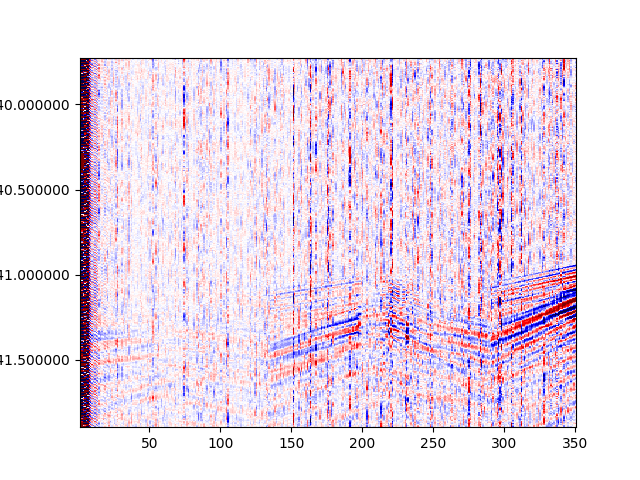

In [598]:
time_to_get = event_arr[:,1][0]
file_time = time_to_get.strftime('%Y-%m-%d_%H.%M')+'.00_UTC.h5'
fname_to_get = '/data/fast1/Eastwind_2425/Eastwind_decimator/Eastwind_decimator/Eastwind_decimator_'+file_time


f = h5py.File(fname_to_get)
attrs = f['Acquisition'].attrs
data = f['Acquisition']['Raw[0]']['RawData'][:]
raw_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
times = sintela_to_datetime(raw_time)
fs = attrs['PulseRate']
dx = attrs['SpatialSamplingInterval']
channels = np.arange(1, attrs['NumberOfLoci']+1,1)

sos = signal.butter(10, [2,100], 'bp', fs=attrs['PulseRate'], output='sos')
filtered = signal.sosfiltfilt(sos, data, axis=0)

data_start = int((event_arr[:,1].min() - datetime.timedelta(seconds=1) - times[0]).total_seconds() * fs)
data_end = int((event_arr[:,1].max()+ datetime.timedelta(seconds=0.5) - times[0]).total_seconds() *fs)

fig, ax = plt.subplots()
ax.pcolormesh(channels[:], times[data_start:data_end], filtered[data_start:data_end,:], cmap='seismic', vmin=-.05,vmax=.05)
#ax.pcolormesh(channels[:], times, filtered, cmap='seismic', vmin=-.05,vmax=.05)
ax.invert_yaxis()

event_data = filtered[data_start:data_end,:]

Output()

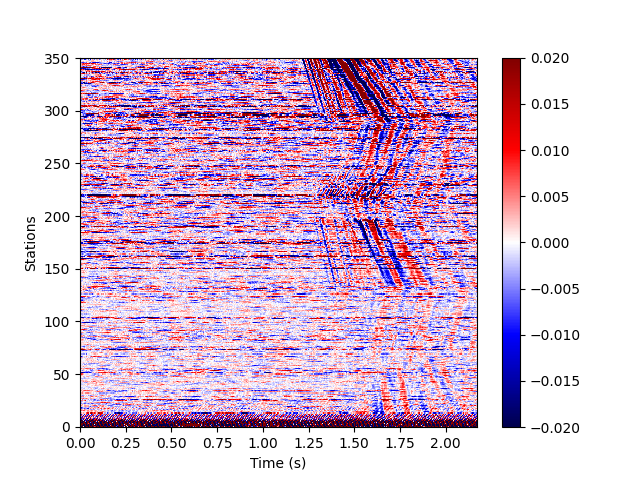

In [602]:
picker = SeismicPicker(times[data_start:data_end], event_data)

In [600]:
picks_all = []

In [603]:
picks = np.array(picker.get_picks())
picks = [(i[0],(i[1].astype(datetime.datetime)- datetime.datetime(1970, 1, 1)).total_seconds()) for i in picks]

picks_all.append(picks)
# with open('basal_event_manual_pick_swave.pkl', 'wb') as f:
#     pkl.dump(picks, f)

In [604]:
manual_pick_dict['Event '+str(event_num)] = picks_all

In [608]:
with open('manual_event_picks_236to288.pkl', 'wb') as f:
    pkl.dump(manual_pick_dict, f)